#Example emulation of PROSAIL using ``gp_emulator``
## J  Gomez-Dans (NCEO & UCL)

The purpose of this notebook is to demonstrate the emulation (and part validation) of the PROSAIL model using the simple GP library produced by UCL. We use the PROSAIL model for convenience: it's fast even on a laptop. A similar approach can be taken with other models of course. You can install the ``gp_emulator`` library directly from the internet using ``pip``. Just execute the next code cell.

In [1]:
! pip install --user https://github.com/jgomezdans/gp_emulator/zipball/master

You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gp_emulator

First, we need to create a training set. To do this, we will just define the bounds of the parameters of PROSAIL. In this case, I'm using the transformations from Weiss et al (check!) that quasi-linarise typical optical RT models. These are however not required you can also emulate on "true units" if you wanted!

In [2]:
parameters = [ 'n', 'cab', 'car', 'cbrown', 'cw', 'cm', 'lai', 'ala', 'bsoil', 'psoil']
min_vals = [ 0.8       ,  0.46301307,  0.95122942,  0.        ,  0.02829699,
            0.03651617,  0.04978707,  0.44444444,  0.        ,  0.]
max_vals = [ 2.5       ,  0.998002  ,  1.        ,  1.        ,  0.80654144,
            0.84366482,  0.99501248,  0.55555556,  2.   , 1     ]
training_set, distributions = gp_emulator.create_training_set ( parameters, min_vals, max_vals, n_train=250 )
print training_set.shape 

(250, 10)


We have now created 200 samples of our 10-element *state vector*. We need to import PROSAIL and make it run for a **particular illumination/acquisition geometry** with the parameters. We can install the PROSAIL bindings for Python easily. Also, note that PROSAIL requires parameters in true units, so we need to have a function to do the inverse transformation handy, in this case ``inverse_transform``. ``do_fwd_model`` is in charge of running the RT model and returning the spectra (note that in some cases you might get ``NaN`` and ``Inf``, so best to check for inconsistencies!)

In [4]:
!pip install --user https://github.com/jgomezdans/prosail/zipball/master

You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 65kB 357kB/s 


In [3]:
sza = 30.
vza = 0.
raa = 0. # in degrees
import prosail

def inverse_transform ( x ):
    """Inverse transform the PROSAIL parameters"""
    x_out = x*1.
    # Cab, posn 1
    x_out[1] = -100.*np.log ( x[1] )
    # Cab, posn 2
    x_out[2] = -100.*np.log ( x[2] )
    # Cw, posn 4
    x_out[4] = (-1./50.)*np.log ( x[4] )
    #Cm, posn 5
    x_out[5] = (-1./100.)*np.log ( x[5] )
    # LAI, posn 6
    x_out[6] = -2.*np.log ( x[6] )
    # ALA, posn 7
    x_out[7] = 90.*x[7]
    return x_out


def do_fwd_model ( x, sza, vza, raa ):
    x = inverse_transform ( x )
    ################# surface refl with prosail #####################
    surf_refl = prosail.run_prosail(x[0], x[1], x[2], x[3], \
        x[4], x[5], x[6], x[7], 0, x[8], x[9], 0.01, sza, vza, raa, 2 )
    return surf_refl

We can now *forward model* our training set using the ``do_fwd_model`` function. We do this in a loop, to obtain 250 spectra between 400 and 2500 nm:

In [6]:
rho_train = []
for p in training_set:
    rho_train.append ( do_fwd_model( p, sza, vza, raa ))
rho_train = np.array ( rho_train )
print rho_train.shape

(250, 2101)


In the next snippet, we create a validation dataset which is made up of 500 (or more, up to you) uniform and independent parameter sets.

In [7]:
validate_set = gp_emulator.create_validation_set( distributions )
rho_validate = []
for p in validate_set:
    rho_validate.append ( do_fwd_model( p, sza, vza, raa ))
    
rho_validate = np.array ( rho_validate )

We just need to feed the emulator this. We select principal components of the spectra that keep a 97% of the variance by setting the ``thresh`` option. The object is created, and the GPs are fitted. Note that to avoid local minima in the fitting, we start at 5 random points in parameter space (for some cases, this can be increased to 15-20 if required!).

In [13]:
gp = gp_emulator.MultivariateEmulator( X=rho_train, y=training_set, thresh=0.97 )

Decomposing the input dataset into basis functions... Done!
 ====> Using 6 basis functions
	Fitting GP for basis function 0
After 5, the minimum cost was -2.501115e+02
	Fitting GP for basis function 1
After 5, the minimum cost was -3.872831e+02
	Fitting GP for basis function 2
After 5, the minimum cost was -3.697352e+02
	Fitting GP for basis function 3
After 5, the minimum cost was -4.350103e+02
	Fitting GP for basis function 4
After 5, the minimum cost was -5.855540e+02
	Fitting GP for basis function 5
After 5, the minimum cost was -7.520969e+02


In [14]:
gp_emulator.MultivariateEmulator?

In [9]:
rho_predict = [] 
rho_predict_sd = []
for p in validate_set:
    r,s = gp.predict ( p )
    rho_predict.append(r)
    rho_predict_sd.append ( s )
    
rho_predict = np.array ( rho_predict )
rho_predict_sd = np.array ( rho_predict_sd )

Let's now plot a few examples (randomly chosen) showing the validation spectrum (full line) and the emulation spectrum (dashed). We will also put the emulation uncertainty ($1\sigma$), which appears to be significantly higher than in our previous attempts (!)

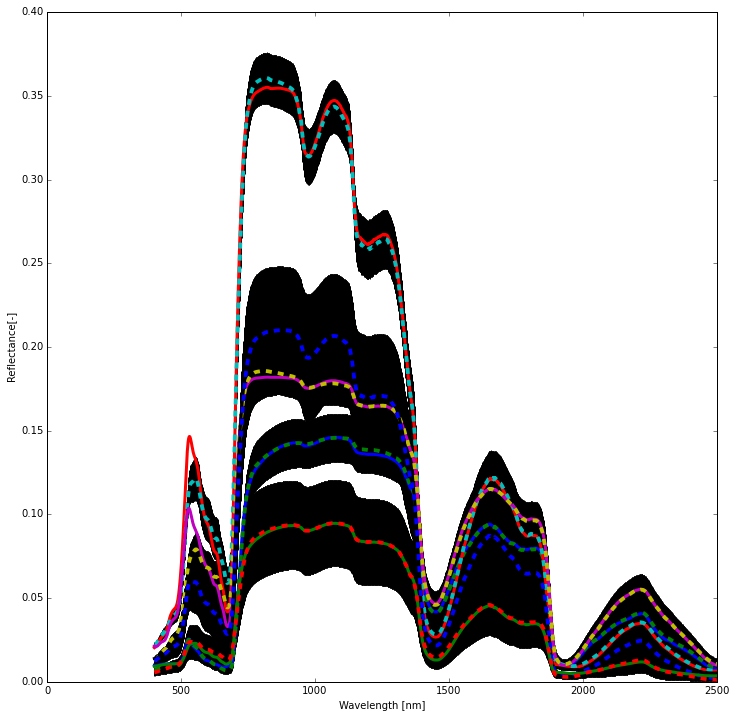

In [10]:
wv = np.arange  (400, 2501 )
plt.figure( figsize=(12,12))
for p in np.random.randint(0,500, 5):

    plt.plot(wv, rho_validate[p,:], '-', lw=3) 
    plt.plot(wv, rho_predict[p,:], '--', lw=3.8)
    plt.vlines ( wv, rho_predict[p,:] -0.5*rho_predict_sd[p,:], rho_predict[p,:] + 0.5*rho_predict_sd[p,:] )
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance[-]")

We can also plot some summary statistics, such as the 95% credible interval, the mean and the median of the residuals

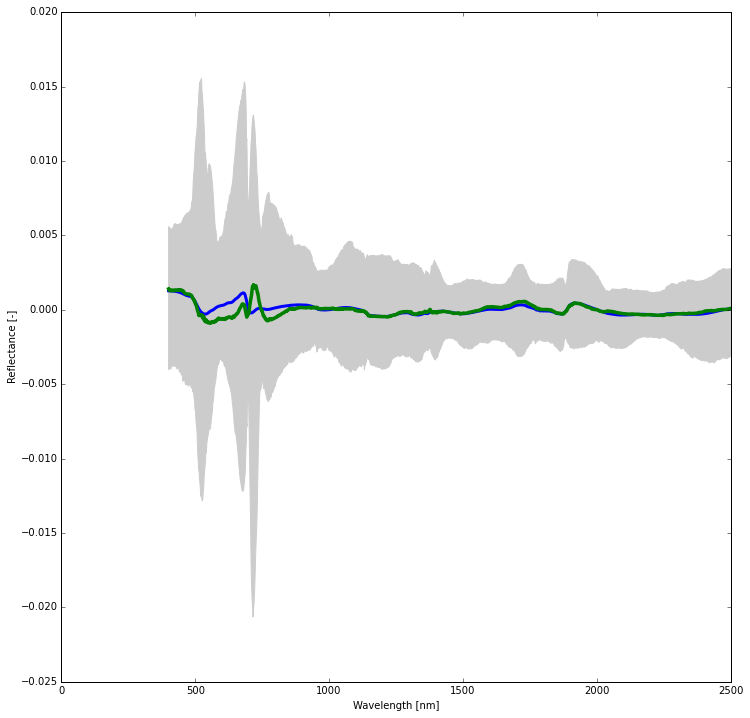

In [11]:
plt.figure(figsize=(12,12))
residual = ( rho_validate - rho_predict )
plt.fill_between( wv, np.percentile( residual, 5, axis=0 ), np.percentile( residual, 95, axis=0 ), color="0.8")
plt.plot ( wv, residual.mean(axis=0), '-', lw=3)
plt.plot ( wv, np.percentile(residual, 50, axis=0), '-', lw=3.5 )
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance [-]")